<a href="https://colab.research.google.com/github/abhinav-exp/Forecasting-CryptoCurrency-Prices/blob/master/TFLANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
GitHubDataLink = 'https://raw.githubusercontent.com/abhinav-exp/Forecasting-CryptoCurrency-Prices/master/Datasets/'
InputFileLink = GitHubDataLink + 'DataBTC2017.csv'
data1 = pd.read_csv(InputFileLink, header=0, index_col=0)
print(data1)

            CBBTCUSD
DATE                
2017-06-18   2515.25
2017-06-19   2596.98
2017-06-20   2725.08
2017-06-21   2643.35
2017-06-22   2679.99
...              ...
2019-08-03  10820.75
2019-08-04  10997.82
2019-08-05  11775.14
2019-08-06  11440.08
2019-08-07  12014.41

[781 rows x 1 columns]


In [3]:
data1min = data1.min()
data1max = data1.max()

normalize = lambda x: (x - data1min + 1)/(data1max - data1min + 2)
data2 = normalize(data1)
print(data2)

            CBBTCUSD
DATE                
2017-06-18  0.034073
2017-06-19  0.038680
2017-06-20  0.045901
2017-06-21  0.041294
2017-06-22  0.043360
...              ...
2019-08-03  0.502247
2019-08-04  0.512228
2019-08-05  0.556045
2019-08-06  0.537158
2019-08-07  0.569532

[781 rows x 1 columns]


In [4]:
def split_sequence(sequence, n_steps):
  X= list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x= sequence.values[i:end_ix, 0]
    X.append(seq_x) 
  return pd.DataFrame(X)

data3 = split_sequence(data2, 10)
print(data3.shape)
print(data3)

(771, 10)
            0         1         2         3         4         5         6  \
0    0.034073  0.038680  0.045901  0.041294  0.043360  0.043967  0.037432   
1    0.038680  0.045901  0.041294  0.043360  0.043967  0.037432  0.033530   
2    0.045901  0.041294  0.043360  0.043967  0.037432  0.033530  0.028023   
3    0.041294  0.043360  0.043967  0.037432  0.033530  0.028023  0.037484   
4    0.043360  0.043967  0.037432  0.033530  0.028023  0.037484  0.036208   
..        ...       ...       ...       ...       ...       ...       ...   
766  0.441959  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307   
767  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562   
768  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501   
769  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030   
770  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030  0.502247   

            7         8         9  
0    0.033530  0.028023  0.03

In [5]:
train_x = data3.iloc[:int(0.85*len(data2)), :9]
train_y = data3.iloc[:int(0.85*len(data2)), 9:10]
test_x = data3.iloc[int(0.85*len(data2)):, :9]
test_y = data3.iloc[int(0.85*len(data2)):, 9:10]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(663, 9)
(663, 1)
(108, 9)
(108, 1)


In [143]:
class TFLANN():
  def __init__(self, learn_rate):
    self.learning_rate = learn_rate
    self.weight_matrix = 2*np.random.random((9*3 + 1, 1)) - 1
  
  def func_x(self, x):
    const_x = np.ones((len(x), 1))
    orginal_x = x
    sinned_x = np.sin(np.pi*x)
    cossed_x = np.cos(np.pi*x)
    functioned_x = np.hstack((x, sinned_x, cossed_x, const_x))
    return functioned_x

  def tanh_derivative(self, x):
    return 1.0 - (np.tanh(x) ** 2)

  def forward_propagation(self, x):
    funced_x = self.func_x(x)
    return np.tanh(np.dot(funced_x, self.weight_matrix))

  def train(self, train_x, train_y, epochs):
    self.me_curve = np.array([])
    for iteration in range(epochs):
      y = self.forward_propagation(train_x)

      error = train_y - y

      adjustment = np.dot( self.learning_rate * self.func_x(train_x).T, error * self.tanh_derivative(y))

      self.weight_matrix += adjustment
      self.me_curve = np.append(self.me_curve, np.mean(error[9]))
      # print(self.mse_curve)
      # print(str(np.mean(error[9] ** 2)) + "\t" + str(np.mean(abs(error[9]))) + "\t" + str(np.mean(train_y[9])) + "\t" + str(np.mean(y[:, 0])) + "\t" + str(np.mean(adjustment[:,0]))) 

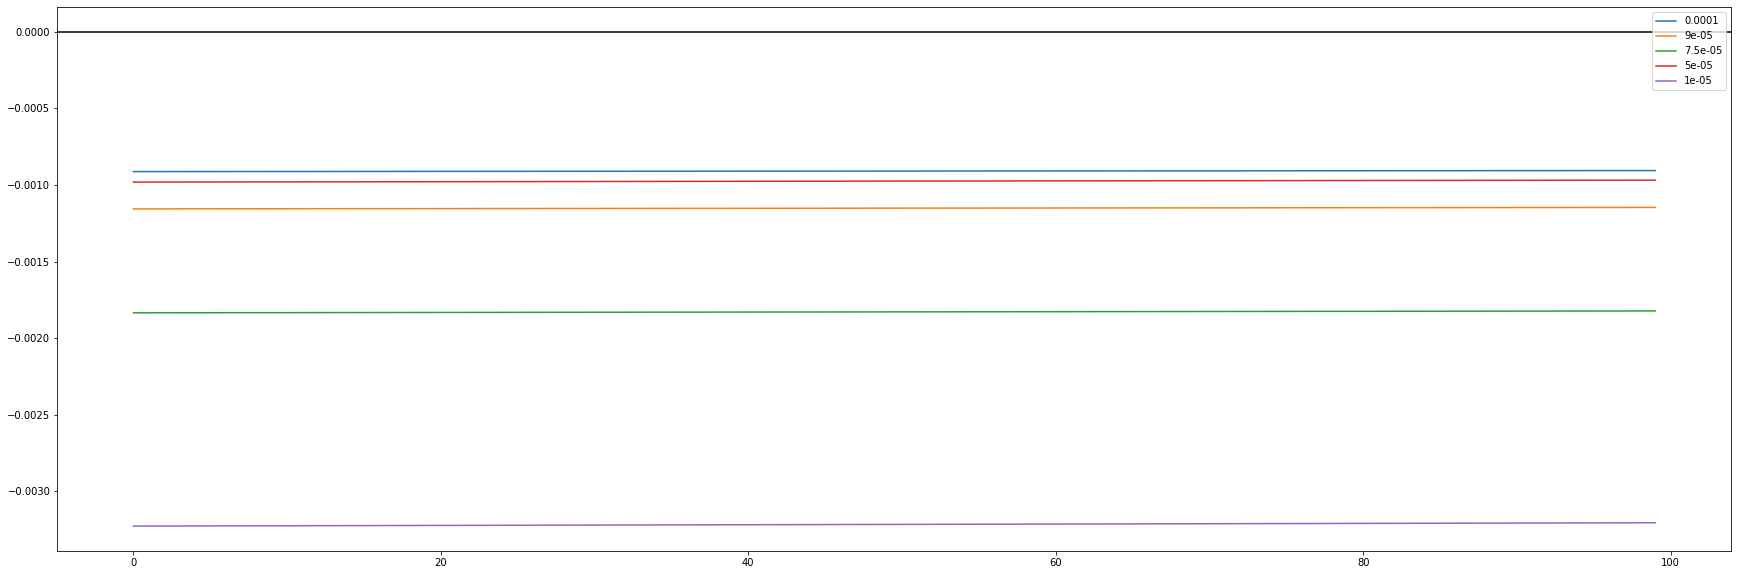

In [186]:
tuning_learning_rates = [0.0001, 0.00009, 0.000075, 0.00005, 0.00001]

plt.figure(figsize = (30, 10))

for t in tuning_learning_rates:
  m = TFLANN(t)
  m.train(train_x = train_x, train_y = train_y, epochs = 10000)
  ec = m.me_curve[-101:-1]
  # print(ec)
  plt.plot(ec)

plt.legend([str(u) for u in tuning_learning_rates])
plt.axhline(y=0, c="black", label="y=0")
plt.show()

In [189]:
model = TFLANN(0.0001)
model.train(train_x = train_x, train_y = train_y, epochs = 10000)
preds = model.forward_propagation(test_x)
print(preds.shape)

(108, 1)


-0.0006631887414733858


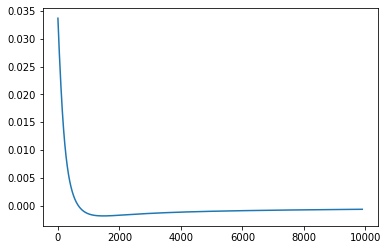

In [190]:
error_curve = model.me_curve[100:]
print(error_curve[-1])
plt.plot(error_curve)
plt.show()

In [191]:
preds[:, 0]

array([0.19261657, 0.17471959, 0.19201156, 0.17537352, 0.20905749,
       0.20846383, 0.16720496, 0.17002035, 0.19341294, 0.17668566,
       0.16663386, 0.17083807, 0.19580725, 0.17197473, 0.20141284,
       0.2191398 , 0.20699099, 0.19930704, 0.20114187, 0.22183339,
       0.22816259, 0.20865509, 0.3153865 , 0.27459938, 0.31944256,
       0.39136799, 0.33326403, 0.39649584, 0.27621964, 0.30385736,
       0.3837045 , 0.35696825, 0.32351847, 0.32874258, 0.30772434,
       0.38133139, 0.33799063, 0.41343271, 0.39610971, 0.37863114,
       0.41889108, 0.3499474 , 0.39279432, 0.4071211 , 0.38534551,
       0.35368929, 0.29469655, 0.34347851, 0.31798552, 0.35066291,
       0.34673411, 0.27912579, 0.35663595, 0.34688399, 0.34349682,
       0.38595059, 0.37606697, 0.42300472, 0.41059651, 0.45441333,
       0.41843351, 0.44083186, 0.48599756, 0.50173922, 0.54562625,
       0.5444821 , 0.58056634, 0.65906233, 0.60872793, 0.56975602,
       0.68181005, 0.5605284 , 0.42557283, 0.59847272, 0.62177

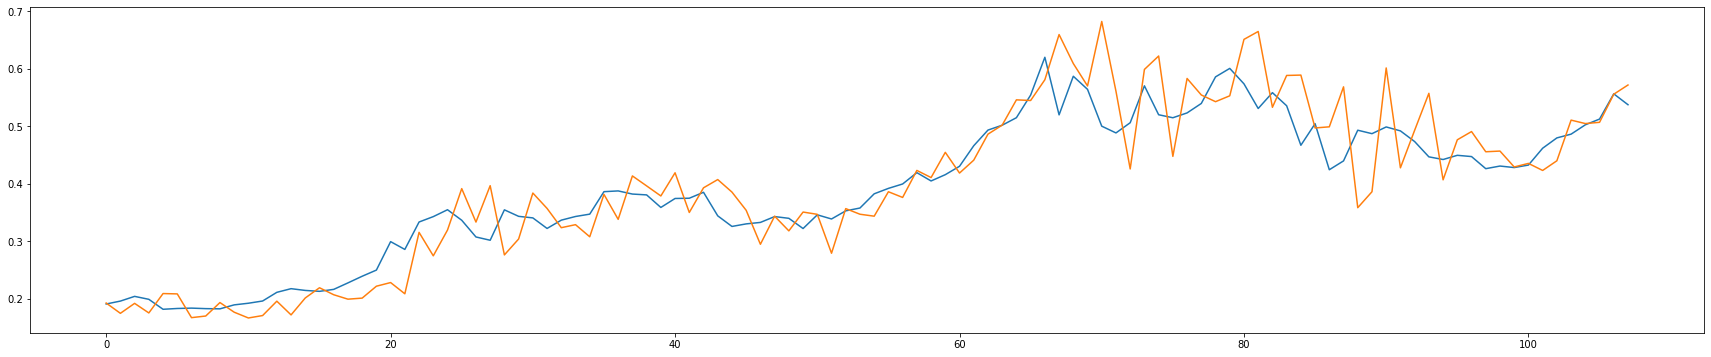

In [193]:
plt.figure(figsize=(30, 6))
plt.plot(test_y.reset_index()[9])
plt.plot(preds)
plt.show()
     